In [48]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')
#import os
#os.getcwd()
#import sys
#sys.path.append('/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats
from scipy.signal import convolve2d
from copy import copy

from math import floor, ceil

import numpy as np
import tensorflow as tf
import logging

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle

import dev_ori_sel_RF 

import plot_func as pf
import util_func as uf

from dev_ori_sel_RF.tools import gen_gaussian_random_field as ggrf
import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,integrator_tf,dynamics,network,run_onelayer,probe_RFs,plasticity_dynamics,run_full_plastic, network_full_plastic, connectivity
from dev_ori_sel_RF import inputs
from dev_ori_sel_RF.tools import misc,update_params_dict,analysis_tools

In [231]:
reload(network_full_plastic)
reload(connectivity)
Version = -1
config_name = 'ffrec_stevens'
Wret_to_lgn,Wlgn_to_4,arbor_on,arbor_off,arbor2,init_weights,W4to4,arbor4to4,init_weights_4to4=uf.get_network_system_ffrec(Version,config_name)

-0.054562602000342075


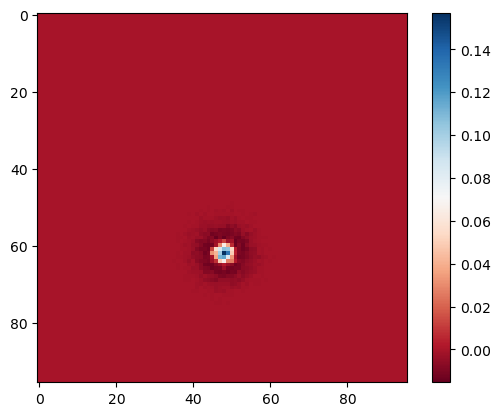

In [226]:
print(np.sum(Wret_to_lgn[5000,:]))

plt.imshow(-Wret_to_lgn[6000,:].reshape(96,96),
        cmap='RdBu')
plt.colorbar()
plt.show()

In [153]:
def distance(delta):
    ''' assume periodic boundary conditions'''
    signs = np.sign(delta)
    return np.where(np.abs(delta) > 0.5, -signs*(1 - np.abs(delta)), delta)
def gaussian(x,y,s):
    return np.exp(-(x**2+y**2)/2./s**2)#1./2.*np.pi/s**2*

from_size = np.array([40,40])
to_size = from_size
Nvert = np.array([1,1])
grid = np.linspace(0,1,from_size[0],endpoint=False)
# grid = np.repeat(grid,self.Nvert[0])
xfrom,yfrom = np.meshgrid(grid,grid)
xfrom = np.repeat(xfrom,Nvert[0]).reshape(from_size[0],from_size[1]*Nvert[0])
yfrom = np.repeat(yfrom,Nvert[0]).reshape(from_size[0],from_size[1]*Nvert[0])
grid = np.linspace(0,1,to_size[0],endpoint=False)
# grid = np.repeat(grid,self.Nvert[1])
xto,yto = np.meshgrid(grid,grid)
xto = np.repeat(xto,Nvert[1]).reshape(to_size[0],to_size[1]*Nvert[1])
yto = np.repeat(yto,Nvert[1]).reshape(to_size[0],to_size[1]*Nvert[1])
xdelta = distance(xto[:,:,None,None]-xfrom[None,None,:,:])
ydelta = distance(yto[:,:,None,None]-yfrom[None,None,:,:])

In [154]:
sigma = 0.3
g = gaussian(xdelta,ydelta,sigma)
#g[0,0,:,:]

In [202]:
kinput = 1
istep=1
jexp = 1
avg_no_inp=1
Version = 0
Nret = 96
Nlgn=96
N4 = 4
config_name = 'ffrec_stevens'
config_dict = misc.load_external_params("params_"+config_name,False)
params_dict = {
                "Version" : tf.constant(Version, dtype=tf.int32),
                "Nlgn" : tf.constant(Nlgn, dtype=tf.int32),
                "N4" : tf.constant(N4, dtype=tf.int32),
                "Nret" : tf.constant(Nret, dtype=tf.int32),
                "Nvert" : tf.constant(Nvert, dtype=tf.int32),
                "config_dict" : config_dict,
                "init_weights" : [tf.convert_to_tensor(init_weights[0],dtype=tf.float32),
                        tf.convert_to_tensor(init_weights[1],dtype=tf.float32)]
                    if "ffrec_postpre_approx" in config_dict["Wlgn_to4_params"]["mult_norm"]
                    else tf.convert_to_tensor(init_weights,dtype=tf.float32),
                "Wret_to_lgn" : tf.convert_to_tensor(Wret_to_lgn,dtype=tf.float32),
                "W4to4" : tf.convert_to_tensor(W4to4, dtype=tf.float32),
}
"Nvert" in params_dict.keys()

True

In [134]:
reload(inputs)
jexp = range(1)[0]
Nret = params_dict["Nret"]
N4 = params_dict["N4"]
Nlgn = params_dict["Nlgn"]
Nvert = params_dict["Nvert"]
rng_seed = params_dict["config_dict"]["random_seed"]*1000 +\
        kinput + istep*avg_no_inp
inp = inputs.Inputs_lgn((Nret,Nret),params_dict["Version"].numpy(),\
    rng_seed)
lgn = inp.create_lgn_input(\
    params_dict["config_dict"]["Inp_params"],\
    params_dict["config_dict"]["Inp_params"]["input_type"],\
    params_dict["Wret_to_lgn"].numpy(),\
    expansion_timestep = jexp,
    )
lgn = inp.apply_ONOFF_bias(lgn,params_dict["config_dict"]["Inp_params"])
## use same inputs for E and I units
num_lgn_paths=4
lgn = np.concatenate([lgn,lgn])
#lgn = tf.convert_to_tensor(lgn.reshape(num_lgn_paths,Nlgn**2),dtype=tf.float32)

(array([2.0034e+04, 1.3760e+03, 1.4900e+03, 1.4800e+03, 1.2600e+03,
        1.3160e+03, 1.2140e+03, 1.0900e+03, 1.0740e+03, 9.3000e+02,
        7.9600e+02, 7.2200e+02, 6.2200e+02, 5.6600e+02, 4.6400e+02,
        4.5600e+02, 3.4600e+02, 3.3600e+02, 2.4200e+02, 2.2800e+02,
        1.7200e+02, 1.5200e+02, 1.2000e+02, 9.0000e+01, 8.0000e+01,
        4.4000e+01, 4.2000e+01, 3.2000e+01, 2.0000e+01, 8.0000e+00,
        1.2000e+01, 1.2000e+01, 1.2000e+01, 4.0000e+00, 4.0000e+00,
        2.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.0561996 , 0.11239919, 0.16859879, 0.22479838,
        0.28099796, 0.33719757, 0.39339715, 0.44959676, 0.50579631,
        0.56199592, 0.61819553, 0.67439514, 0.73059469, 0.7867943 ,
        0.84299392, 0.89919353, 0.95539308, 1.01159263, 1.0677923 ,
        1.12399185, 1.18019152, 1.23639107, 1.

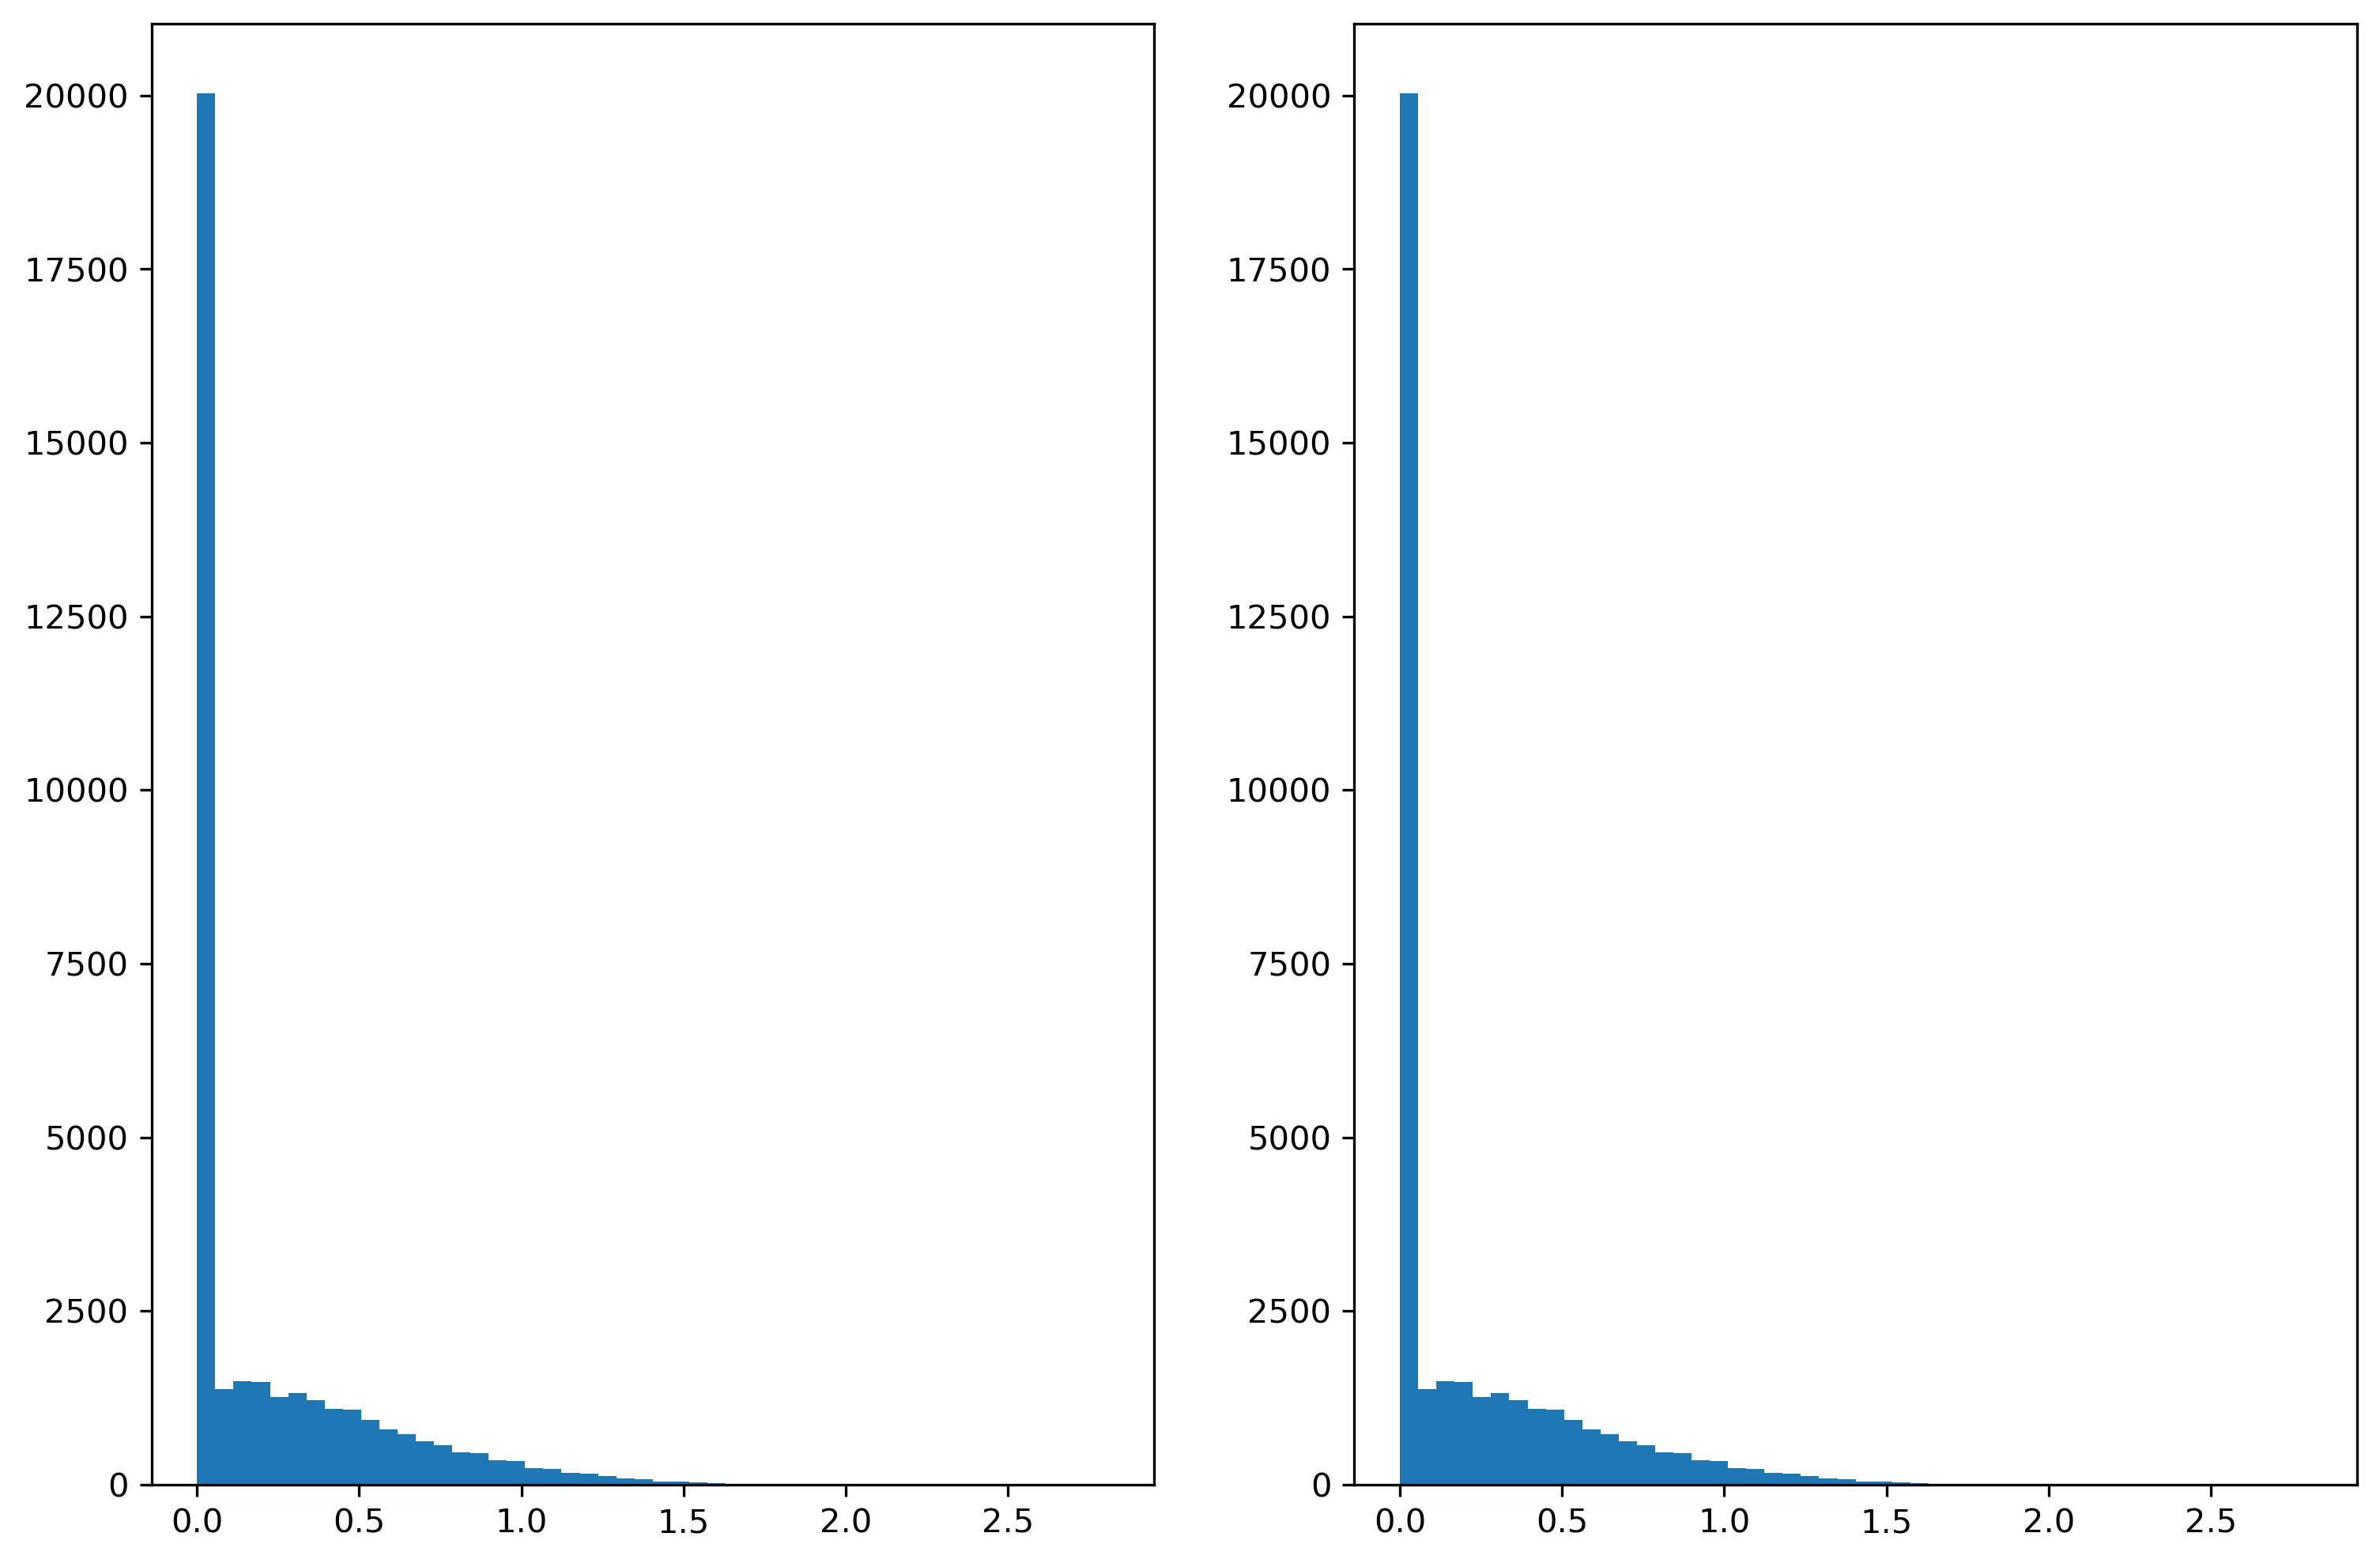

In [185]:
fig,axs = plt.subplots(1,2,figsize=(12,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

axs[0].hist(lgn.flatten(),50)
axs[1].hist(lgn.flatten(),50)

1.0


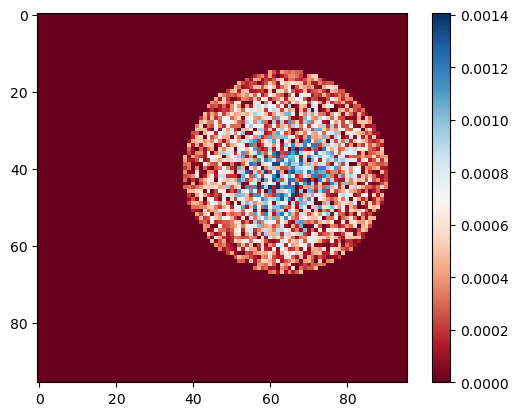

In [230]:
singlegaussian=Wlgn_to_4[2,4000,:].reshape(96,96)
print(np.sum(singlegaussian))
plt.imshow(singlegaussian,
        cmap='RdBu')
plt.colorbar()
plt.show()

(18432, 18432)
3.5519999999999996


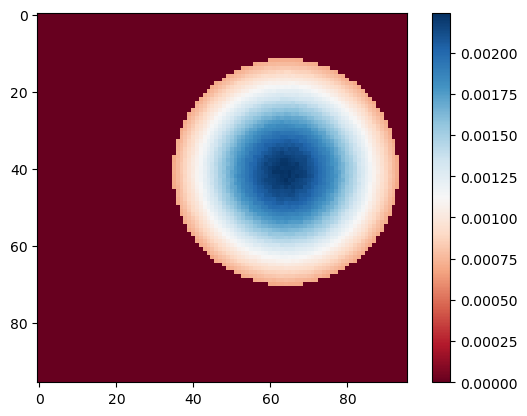

In [224]:
print(W4to4.shape)
N4 = W4to4.shape[0]//2
singlegaussian4to4 = W4to4[:N4,:N4][4000,:]
print(np.sum(singlegaussian4to4))
plt.imshow(singlegaussian4to4.reshape(96,96),cmap='RdBu')
plt.colorbar()
plt.show()

In [ ]:
            elif "u_noise" in conn_params.keys():
                u_noise = conn_params["u_noise"]
                sigma = conn_params["sigma_P"]
                disc_gaussian = gaussian(xdelta,ydelta,sigma)
                noise_field = self.rng.uniform(1-u_noise,1,xdelta.size)
                conn_matrix = disc_gaussian * noise_field.reshape(disc_gaussian.shape)
                norm_factor = np.sum(conn_matrix,axis=(0,1))[None,None,:,:]
                conn_matrix /= norm_factor
                in line 454